# Simulation of Neural Responses to Classical Music Using Organoid Intelligence Methods

In [2]:
%pip install mne scipy librosa pyorganoid[all] pandas

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\actes\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import os
import mne
import librosa
import numpy as np
import pandas as pd
import pyorganoid as po
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import welch
__import__("warnings").filterwarnings("ignore")

In [4]:
data_dir = Path('data')

# Load data for the first subject (for sample reference)
from utils import load_eeg_data
raw_eeg = load_eeg_data(data_dir, 1)
print(raw_eeg.info)

Opening raw data file data\eeg\sub-01\sub-01_task-classicalMusic_eeg_part0.fif...
Isotrak not found
    Range : 0 ... 299999 =      0.000 ...   299.999 secs
Ready.
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Opening raw data file data\eeg\sub-01\sub-01_task-classicalMusic_eeg_part1.fif...
Isotrak not found
    Range : 300000 ... 599999 =    300.000 ...   599.999 secs
Ready.
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Opening raw data file data\eeg\sub-01\sub-01_task-classicalMusic_eeg_part2.fif...
Isotrak not found
    Range : 600000 ... 899999 =    600.000 ...   899.999 secs
Ready.
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Opening raw data file data\eeg\sub-01\sub-01_task-classicalMusic_eeg_part3.fif...
Isotrak not found
    Range : 900000 ... 1199999 =    900.000 ...  1199.999 secs
Ready.
Reading 0 ... 299999  =      0.000 ...   299.999 secs...
Opening raw data file data\eeg\sub-01\sub-01_task-classicalMusic_eeg_part4.fif...
Isotrak not found


Filtering raw data in 7 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using matplotlib as 2D backend.


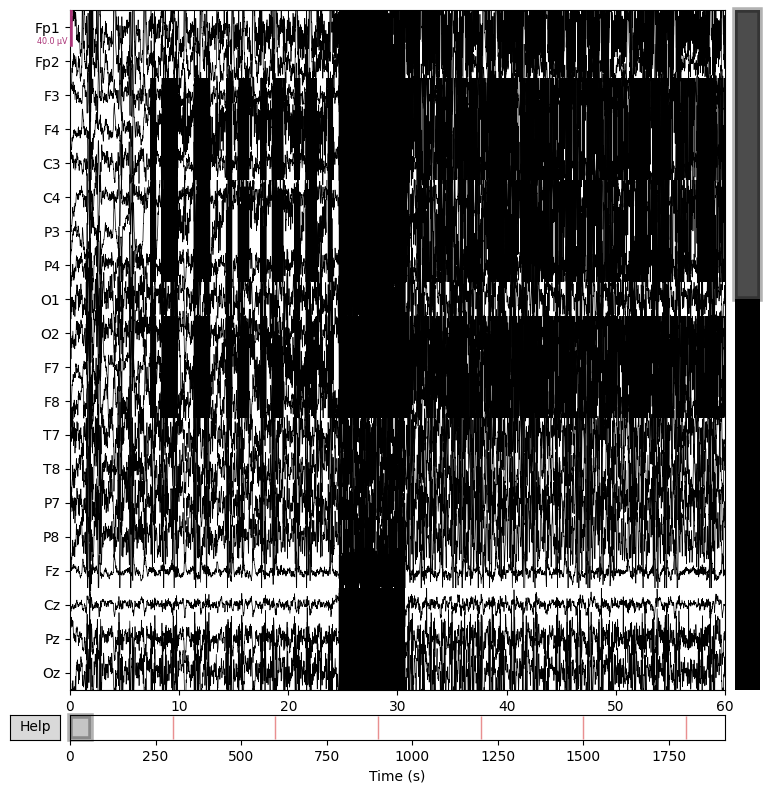

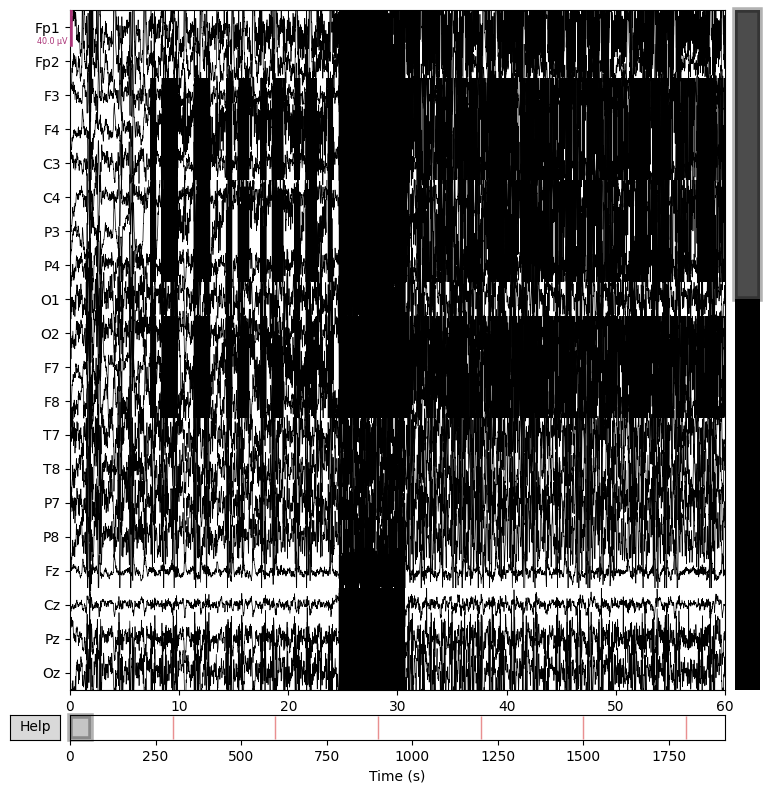

In [5]:
# Filtering the data to remove low frequency drifts and high frequency noise
raw_eeg.filter(1., 40., fir_design='firwin')
raw_eeg.plot(duration=60, n_channels=20)  # May need to modify

In [6]:
# Continued preprocessing
ica = mne.preprocessing.ICA(n_components=20, random_state=97)
ica.fit(raw_eeg)
raw = ica.apply(raw_eeg)  # Apply ICA for artifact correction

Fitting ICA to data using 46 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 60.8s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 46 PCA components


In [7]:
print(raw.ch_names)  # Channel names

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'ft_valance', 'ft_arousal', 'ft_x', 'ft_y', 'ft_ghostvalence', 'ft_ghostarousal', 'music', 'trialtype', 'sams_valence', 'sams_arousal', 'sams_valencert', 'sams_arousalrt', 'nback_stimuli', 'nback_keypress', 'Status']


In [8]:
events = mne.find_events(raw, stim_channel='Status', initial_event=True, min_duration=1/raw.info['sfreq'], shortest_event=1)
print(events)

2253 events found on stim channel Status
Event IDs: [    9    46   265   767  1282 34053]
[[      0       0    1282]
 [    912       0     265]
 [   1500       0   34053]
 ...
 [1909800       0      46]
 [1911800       0      46]
 [1913800       0      46]]


Events detected: 2253
Unique event IDs: [    9    46   265   767  1282 34053]


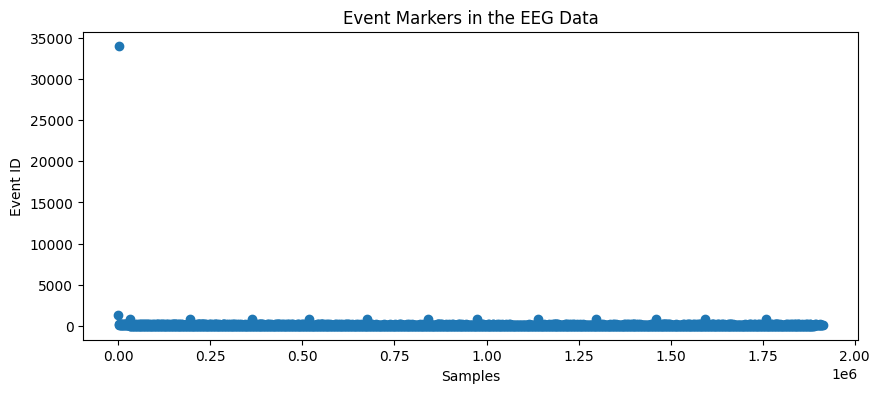

In [9]:
print("Events detected:", len(events))
print("Unique event IDs:", np.unique(events[:, 2]))

plt.figure(figsize=(10, 4))
plt.plot(events[:, 0], events[:, 2], 'o')
plt.title('Event Markers in the EEG Data')
plt.xlabel('Samples')
plt.ylabel('Event ID')
plt.show()

In [11]:
from utils import load_eeg_events
events_df = load_eeg_events(data_dir, subject_id=1)
events_df

,onset,duration,trial_type
0,0.001,0.001,1
1,0.001,0.001,47
2,0.001,0.001,1283
3,0.913,0.001,1285
4,0.913,0.001,265
...,...,...,...
2251,1906.102,0.001,265
2252,1907.801,0.001,47
2253,1909.801,0.001,47
2254,1911.801,0.001,47


In [12]:
events_df['onset_samples'] = (events_df['onset'] * raw_eeg.info['sfreq']).astype(int)
events_array = np.column_stack((events_df['onset_samples'], np.zeros(len(events_df), dtype=int), events_df['trial_type']))
print(events_array)

[[      1       0       1]
 [      1       0      47]
 [      1       0    1283]
 ...
 [1909801       0      47]
 [1911801       0      47]
 [1913801       0      47]]


In [13]:
event_id = {str(int(evt)): int(evt) for evt in np.unique(events_df['trial_type'])}
epochs = mne.Epochs(raw_eeg, events_array, event_id=event_id, tmin=-0.2, tmax=10.0, baseline=(None, 0), preload=True, event_repeated='merge')

Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
2253 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2253 events and 10201 original time points ...
80 bad epochs dropped


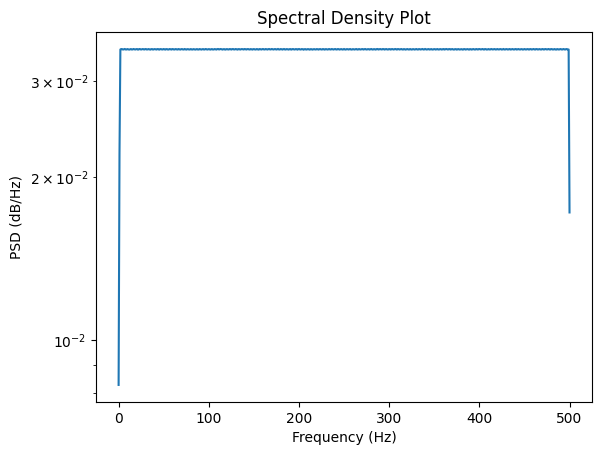

In [14]:
def plot_psd(data):
    if not data.preload:
        data.load_data()

    data_np = data.get_data()
    sfreq = data.info['sfreq']

    # Initialize a list to store PSDs from each channel
    psds_list = []

    # Calculate PSD for each channel
    for channel_data in data_np:
        freqs, psd = welch(channel_data, fs=sfreq, nperseg=1024)
        psds_list.append(psd)

    # Convert list to numpy array for ease of computation
    psds = np.array(psds_list)

    # Compute the average PSD across channels
    psd_mean = np.mean(psds, axis=0)

    # Plotting
    f, ax = plt.subplots()
    ax.semilogy(freqs, psd_mean)
    ax.set_title('Spectral Density Plot')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (dB/Hz)')
    return ax, freqs, psd_mean

# Plot the PSD for the first epoch
ax, freqs, psd_mean = plot_psd(raw_eeg)
plt.show()

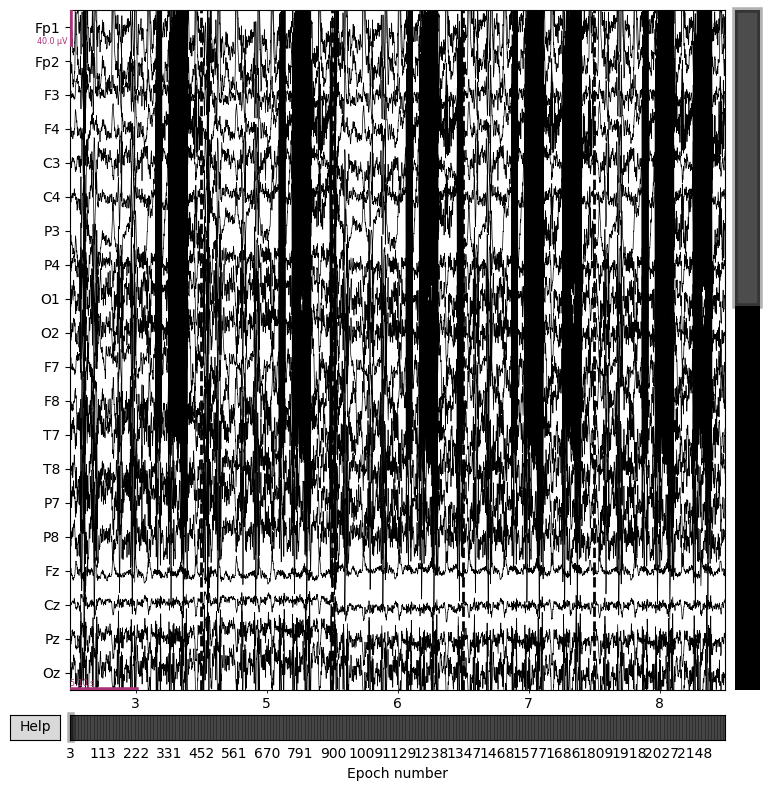

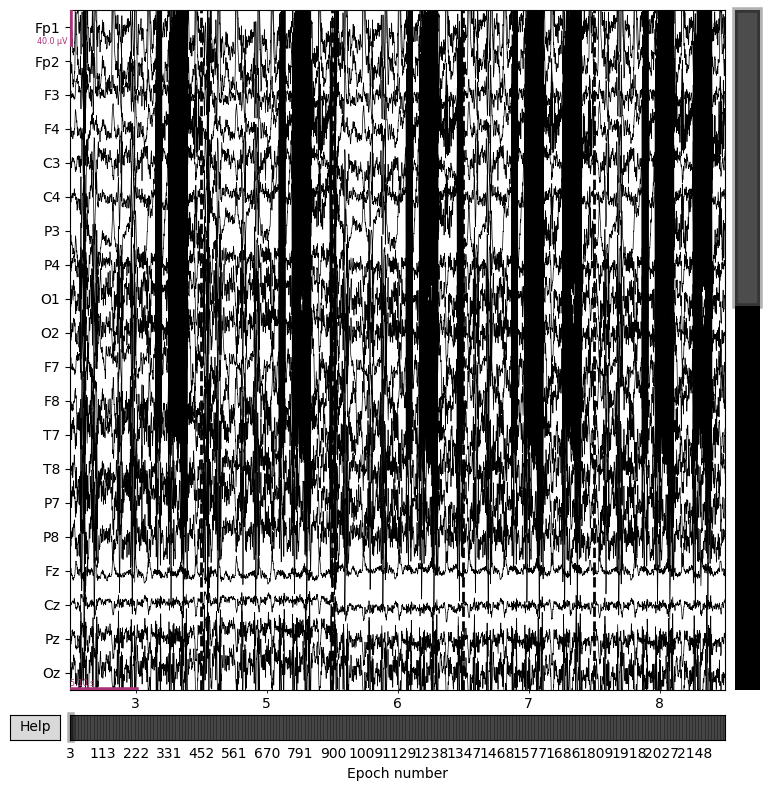

In [17]:
epochs.plot(n_channels=20, n_epochs=5)